In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')
import sys
#add github home folder /Ctherm_thermo and /Ctherm_thermo/scripts
sys.path.append('/Users/satyakam/Dropbox/work/component_contribution_ctherm/')
sys.path.append('/Users/satyakam/Dropbox/work/component_contribution_ctherm/scripts')

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 14 18:32:46 2014

@author: noore
"""
import json
import sys,pdb
#sys.path.append("../")
from scripts.max_min_driving_force import KeggFile2ModelList, MaxMinDrivingForce
from component_contribution.component_contribution_trainer import ComponentContribution
from scripts.html_writer import HtmlWriter
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# REACTION_FNAME = '../examples/cterm_butanol.txt'
# HTML_FNAME = '../res/mdf_cterm_butanol.html'

HTML_FNAME = './examples/res_ctherm_pyk/'

REACTION_FNAMES = ['./examples/cterm_120218_P1.txt',
                   './examples/cterm_120218_P4_malate_shunt.txt',
                   './examples/cterm_120218_P7_PYK.txt']
saveDirs = ["P1_ppdk",
            "P4_malate_shunt",
            "P7_pyk"]
ratio = [1]
exp_data_file = "ctherm_exp_data.txt"
exp_data = []
all_data = {}
f = open(exp_data_file, "r")
l = f.readline()
l = f.readline()
mets_constr = [i for i in l.strip("\n").split(" ") if i != ""]
l = f.readline()
while l != "":
    data = [float(i) for i in l.strip("\n").split(" ") if i != ""]
    exp_data.append(dict(zip(mets_constr, data)))
    l = f.readline()

f.close()

'''ref_conc0 = {'C00469': 1,
            'C00004': 0.08,
            'C00024': 0.83,
            'C00002': 2.70,
            'C00008': 0.11,
            'C00020': 0.22,
            'C00354': 1.50,
            'C00092': 8.19,
            'C00085': 1.49,
            'C00103': 6.66,
            'C00118': 0.10,
            'C00197': 1.35,
            'C00011': 1.27,
            'C00074': 0.69,
            'C00005': 0.39,
            'C00003': 2.25,
            'C00006': 0.26,
            'C00010': 0.02,
            'C00022': 12.66,
            'C00103': 6.66,
            'C00044': 0.28,
            'C00035': 0.01
            }'''
ref_conc0 = {'C00469': 10,
            'C00004': 0.08,
            'C00024': 0.83,
            'C00002': 2.70,
            'C00008': 0.11,
            'C00020': 0.22,
            'C00354': 1.50,
            'C00092': 8.19,
            'C00074': 0.69,
            'C00005': 0.38,
            'C00022': 12.65,
            'C00103': 6.66
            }


for k in range(len(saveDirs)):
    pathways = KeggFile2ModelList(REACTION_FNAMES[k])
    p = pathways[0]
    cc = ComponentContribution.init()
    all_data[k] ={}
    p['model'].add_thermo(cc)
    cid = p['model'].cids
    ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.iteritems()}
    for cpd, conc in ref_conc.iteritems():
        p['bounds'][cpd] = (conc * 0.67, conc * 1.75)
    for r in ratio:
        dictCur ={}
        all_data[k][r] ={}
        # fix PPI/PI ratio
        p['bounds']['C00013'] = (1e-3 * 10, ) * 2
        p['bounds']['C00009'] = (1e-3 * 10, ) * 2
        # vary fdred conc
        #ref_conc['C00138'] = (0.01 * r * 1e-3)
        #ref_conc['C00139'] = (0.01 * 1e-3)
        #p['bounds']['C00035'] = (1e-3 * 10, ) * 2
        ref = True
#        ref_conc = {}
        t = 0
        #print p["bounds"]
        for d in exp_data:
            for cpd, conc in ref_conc.iteritems():
                if cpd == "C00469":
                    # absolute EtOH conc
                    p['bounds'][cpd] = (d[cpd], d[cpd])
                elif cpd == "C00004":
                    # NADH/NAD+ ratio
                    p['bounds'][cpd] = (0.67 * conc * float(d[cpd]) / 0.3, 1.75 * conc * float(d[cpd]) / 0.3)
                elif cpd == "C00035":
                    # NADH/NAD+ ratio
                    p['bounds'][cpd] = (0.67 * conc * float(d['C00002']), 1.75 * conc * float(d['C00002']))
                #elif cpd == "C00008" and t == 0:
                    #p['bounds'][cpd] = (conc, ) * 2
                elif cpd not in ["C00008","C00085","C00006","C00003","C00118","C00011","C00197","C00010","C00044"]:
                    # other relative data
                    p['bounds'][cpd] = (0.67 * conc * d[cpd], 1.75 * conc * d[cpd])

            html_writer = HtmlWriter(HTML_FNAME + saveDirs[k] + "/atp%d_t%d.html" %(r, t))
            mdf = MaxMinDrivingForce(p['model'], p['fluxes'], p['bounds'],
                                 pH=p['pH'], I=p['I'], T=p['T'],
                                 html_writer=html_writer)


            mdf_solution, dG_r_prime, param = mdf.Solve(uncertainty_factor=3.0)
            plt.close()
            # store the data
            dictCur[t] = {'mdf': mdf_solution}
            dictCur[t]["reaction prices"] = {p["model"].rids[k]: float(param["reaction prices"][k]) for k in range(len(p["model"].rids))}
            dictCur[t]["gibbs energies"] = {p["model"].rids[k]: float(param["gibbs energies"][k]) for k in range(len(p["model"].rids))}
            dictCur[t]["concentrations"] = {p["model"].cids[k]: float(param["concentrations"][k]) for k in range(len(p["model"].cids))}
            dictCur[t]["compound prices"] = {p["model"].cids[k]: float(param["compound prices"][k]) for k in range(len(p["model"].cids))}

            all_data[k][r] = dictCur
            t += 1


            if ref:
                ref = False
                conc_list = [x[0] for x in param['concentrations'].tolist()]
                ref_conc_comput = dict(zip(cid, conc_list))
                for c in cid:
                    if c in mets_constr and c not in ref_conc:
                        ref_conc[c] = ref_conc_comput[c]

Academic license - for non-commercial use only


In [3]:
import seaborn as sns
sns.set()
mdf_data={}
for k in range(3):
    mdf_data[k]={}
    for r in [1]:
        mdf_data[k][r]={}
        for t in range(10):
            mdf_data[k][r][t] = all_data[k][r][t]["mdf"]

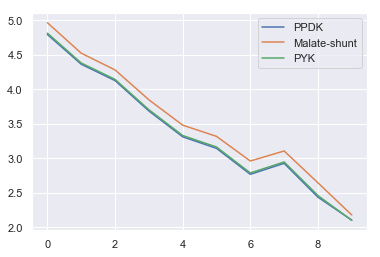

In [4]:
y={}
for k in range(3):
    y[k]={}
    for t in range(10):
        y[k][t] = float(mdf_data[k][1][t]) 
import pandas as pd
df = pd.DataFrame.from_dict(y)

plt.plot(df)
plt.legend(['PPDK','Malate-shunt','PYK'])
#plt.xlabel('time points')
#plt.ylabel('MDF')
#plt.title('MDF vs timepoints')

Text(0.5,1,'sensitivity of PPI_PFK vs timepoints')

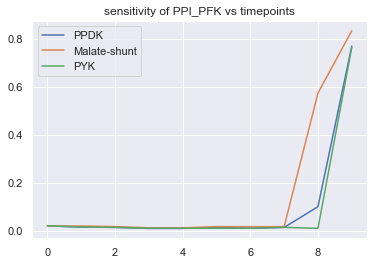

In [5]:
import seaborn as sns
sns.set()
fng_data={}
for k in range(3):
    fng_data[k]={}
    for r in [1]:
        fng_data[k][r]={}
        for t in range(10):
            fng_data[k][r][t] = all_data[k][r][t]["reaction prices"]["PPI_PFK"]
z={}
for k in range(3):
    z[k]={}
    for t in range(10):
        z[k][t] = float(fng_data[k][1][t]) 
import pandas as pd
df = pd.DataFrame.from_dict(z)
plt.plot(df)
plt.legend(['PPDK','Malate-shunt','PYK'])
plt.title('sensitivity of PPI_PFK vs timepoints')